In [2]:
import os
import random
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

sys.path.append('../')

from modules.datasets import StateGridSet
from modules.networks import Perception, Policy
from modules.utils import alive_mask, load_emoji, stochastic_update_mask

%matplotlib inline

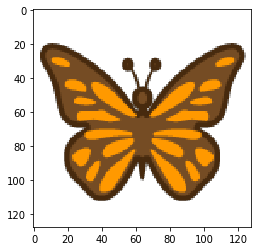

In [17]:
plt.imshow(load_emoji('🦋'))

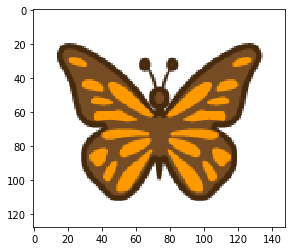

In [25]:
plt.imshow(F.pad(torch.from_numpy(load_emoji('🦋')).unsqueeze(0), (0, 0, 10, 10), value=0)[0].data.numpy())

In [31]:
torch.from_numpy(load_emoji('🦋')).permute(2, 0, 1).shape

torch.Size([4, 128, 128])

In [33]:
F.pad(torch.from_numpy(load_emoji('🦋')).permute(2, 0, 1).unsqueeze(0), (10, 10, 10, 10), value=0)[0].data.numpy().shape

(4, 148, 148)

In [3]:
alpha = torch.rand((1, 1, 128, 128))

In [14]:
F.pad(alpha, (10, 10, 10, 10), value = 0).shape

torch.Size([1, 1, 148, 148])

In [12]:
F.interpolate(alpha[0], (1, 64, 64)).shape

RuntimeError: It is expected output_size equals to 1, but got size 3

In [7]:
(nn.MaxPool2d(3, stride=1, padding=1)(alpha) > 0.1).shape

torch.Size([1, 1, 128, 128])

In [7]:
torch.__version__

'1.2.0'

In [8]:
device = 'cuda:0'
stochastic_prob = 0.1
batch_size = 4
num_epochs = 2000
output_folder = './outputs/'

tensor(1., device='cuda:0') tensor(-1., device='cuda:0') tensor(-0.6083, device='cuda:0')


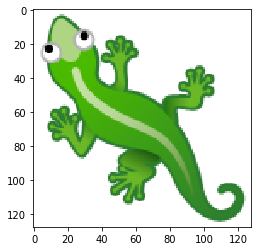

In [9]:
img = load_emoji(emoji='🦎')
img = transforms.ToTensor()(img)
img = transforms.Normalize(tuple(0.5 for _ in range(img.shape[0])),
                                          tuple(0.5 for _ in range(img.shape[0])))(img)
img = img.to(device)
print(img.max(), img.min(), img.mean())
plt.imshow((img.cpu().permute(1, 2, 0).data.numpy() + 1.) / 2.)

In [10]:
policy = Policy(use_embedding=False, kernel=1, padding=0).to(device)
perception = Perception(channels=16).to(device)
optim = torch.optim.Adam(list(policy.parameters()) + list(perception.parameters()), lr=2e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 100, gamma=0.7)
loss_fn = nn.MSELoss()

In [18]:
for p in policy.parameters():
    p.grad.data /= (p.grad.data.norm(2) + 1e-8)

In [14]:
dset = StateGridSet(emoji='🦎', use_coords=True, batch_size=batch_size, random_spawn=False)
dset_test = StateGridSet(emoji='🦎', use_coords=True, batch_size=1, random_spawn=False)
dloader = DataLoader(dset, batch_size=batch_size)
dloader_test = DataLoader(dset, batch_size=1)

In [16]:
xv, yv = torch.meshgrid([torch.linspace(-1, 1, steps=img.shape[-1]),
                         torch.linspace(-1, 1, steps=img.shape[-2])])

for epoch in range(num_epochs):
    n_steps = random.randint(100, 150)
    split_rate = random.randint(30, 40)
    for state_grid, target in dloader:
        state_grid, target = state_grid.to(device), target.to(device)
        for k in range(n_steps):
            alive_pre = alive_mask((state_grid + 1.) / 2., thr=0.1)
            perception_grid = perception(state_grid)
            ds_grid = policy(perception_grid)
            mask = stochastic_update_mask(ds_grid,
                                          prob=stochastic_prob)
            state_grid = state_grid + ds_grid * mask
            alive_post = alive_mask((state_grid + 1.) / 2., thr=0.1)
            final_mask = (alive_post.bool() & alive_pre.bool()).float()
            state_grid = state_grid * final_mask

            if dset.use_coords:
                state_grid[:, -1, ...] = xv[None, :, :]
                state_grid[:, -2, ...] = yv[None, :, :]

            if k % split_rate == 0:
                loss_value = loss_fn(target[:, :4, ...],
                                     state_grid[:, :4, ...])
                optim.zero_grad()
                loss_value.backward()
                optim.step()
                state_grid = state_grid.detach()

    if k % split_rate == 0:
        pass
    else:
        loss_value = loss_fn(target[:, :4, ...], state_grid[:, :4, ...])
        optim.zero_grad()
        loss_value.backward()
        optim.step()
    scheduler.step()
    print(f'{loss_value.item():.2f}, {n_steps} steps, ',
          f'{split_rate} split rate, {epoch} epoch')
    if epoch % 50 == 0:
        print('Testing')
        output_path = os.path.join(output_folder, f'{epoch}/')
        os.makedirs(output_path, exist_ok=True)
        test(policy, perception, dloader_test,
             output_path, num_steps=150,
             stochastic_prob=stochastic_prob)


0.58, 116 steps,  37 split rate, 0 epoch
Testing


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same